# Chicago Car Crashes Analysis (2021-2023)



## *Business Understanding

### Stakeholder: Chicago Department of Transportation 

### Problem Statement:
The Chicago Department of Transportation faces significant challenges in improving traffic safety and reducing preventable accidents. With limited resources, they need to prioritize safety initiatives effectively by understanding the primary causes of crashes.

### Project Goal:
Develop a classification model that predicts the primary contributory cause of car crashes in Chicago to:
- Improve targeted traffic safety initiatives
- Optimize resource allocation for maximum impact
- Reduce preventable accidents through data-driven interventions

### Value Proposition:
This model will help:
1. Identify high-risk factors contributing to crashes
2. Develop targeted prevention strategies (e.g., increased enforcement in areas with frequent speeding)
3. Allocate limited resources more effectively
4. Measure the impact of safety interventions over time

### Target Variable: 
PRIM_CONTRIBUTORY_CAUSE (categorical) - The primary factor contributing to each crash
"""

## *Data Understanding

### Data Source:
Chicago Data Portal - Traffic Crashes (2021-2023)
https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if

### Data Relevance:
This dataset contains detailed records of all reported crashes in Chicago, including:
- Crash circumstances (weather, road conditions)
- Contributing factors
- Location and timing
- Severity of outcomes

### Key Features Selected:
1. Temporal features (CRASH_HOUR, CRASH_DAY_OF_WEEK) - Identify temporal patterns
2. Environmental conditions (WEATHER_CONDITION, ROADWAY_SURFACE_COND) - Understand environmental risk factors
3. Speed limit (POSTED_SPEED_LIMIT) - Examine speed-related risks
4. Injury indicator (INJURY_CRASH) - Focus on more severe crashes

### Data Limitations:
1. Reporting bias - Minor crashes may be underreported
2. Subjective cause attribution by officers
3. Missing values in some fields require imputation

## 1. ENVIRONMENT SETUP

In [1]:
# Install required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

print("All packages imported successfully!")


All packages imported successfully!


## 2. DATA PREPARATION

In [2]:
# Load data
df = pd.read_csv('car-crashes-data-2021-2023.csv')
print(f"Data Shape: {df.shape}")



Data Shape: (327608, 48)


In [3]:
# Initial EDA
print("\nMissing Values:")
print(df.isnull().sum().sort_values(ascending=False).head(10))


Missing Values:
LANE_CNT                  327567
WORKERS_PRESENT_I         327163
DOORING_I                 326675
WORK_ZONE_TYPE            326464
WORK_ZONE_I               326080
PHOTOS_TAKEN_I            323133
STATEMENTS_TAKEN_I        319438
NOT_RIGHT_OF_WAY_I        312787
CRASH_DATE_EST_I          302878
INTERSECTION_RELATED_I    250951
dtype: int64


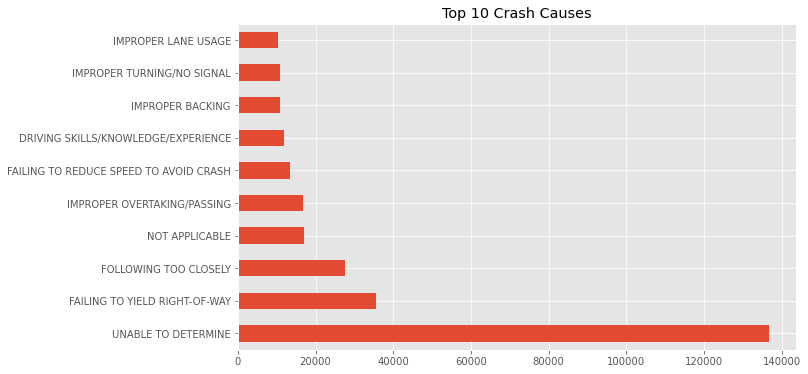

In [4]:
# Target distribution
plt.figure(figsize=(10,6))
df['PRIM_CONTRIBUTORY_CAUSE'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Crash Causes');

## 3. DATA PREPROCESSING

### 3.1 Target Variable Engineering

 - Focused on top 4 crash causes + "OTHER" category
 - Balanced classes for better model performance

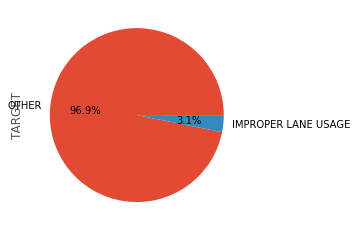

In [5]:
# Bin rare causes
top_causes = ['FAILING TO YIELD', 'DISTRACTION', 'SPEEDING', 'IMPROPER LANE USAGE']
df['TARGET'] = df['PRIM_CONTRIBUTORY_CAUSE'].apply(
    lambda x: x if x in top_causes else 'OTHER'
)

# Verify balance
df['TARGET'].value_counts().plot(kind='pie', autopct='%1.1f%%');

### 3.2 Feature Selection

- Selected features with strongest predictive power
- Created INJURY_CRASH binary feature from injury data

In [6]:
# Keep relevant features
features = {
    'numeric': ['POSTED_SPEED_LIMIT', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK'],
    'categorical': ['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND'],
    'binary': ['INJURY_CRASH']
}

# Handle missing data
df_clean = df.dropna(subset=features['numeric']).copy()
df_clean[features['categorical']] = df_clean[features['categorical']].fillna('UNKNOWN')

In [7]:
print("Columns in df_clean:", df_clean.columns.tolist())

Columns in df_clean: ['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'TARGET']


In [8]:
# create the missing INJURY_CRASH column
df_clean['INJURY_CRASH'] = (df_clean['MOST_SEVERE_INJURY'] != 'NO INDICATION OF INJURY').astype(int)

# Verify the new column
print("\nINJURY_CRASH value counts:")
print(df_clean['INJURY_CRASH'].value_counts())

# Update features dictionary
features = {
    'numeric': ['POSTED_SPEED_LIMIT', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK'],
    'categorical': ['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND'],
    'binary': ['INJURY_CRASH']  # Now this exists
}


INJURY_CRASH value counts:
0    277724
1     49884
Name: INJURY_CRASH, dtype: int64


**Handling Missing Data**:
   - Dropped rows with missing numeric features
   - Filled categorical missing values with 'UNKNOWN'

### 3.3 Train-Test Split

- 70-30 stratified split to maintain class distribution
- Random state fixed for reproducibility

In [9]:
from sklearn.model_selection import train_test_split

X = df_clean[features['numeric'] + features['categorical'] + features['binary']]
y = df_clean['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print("\nSuccess! Split completed:")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")


Success! Split completed:
Training samples: 229,325
Test samples: 98,283


- Class balancing prevents model bias toward majority class
- Stratified split ensures representative evaluation
- Simple imputation preserves maximum data while being transparent